In [1]:
from FLENN import FLENN

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import matplotlib.ticker as mtick
import numpy as np
from time import time
import math
from matplotlib import patches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import glob
from sklearn.preprocessing import MinMaxScaler
from distribution import TestDistribution
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


In [2]:
n_train_vec = [6000,4000,2000]
n_test = 5000

X_train_vec = [np.random.rand(n_train).reshape(-1, 1) for n_train in n_train_vec]
y_train_vec = [np.sin(X_train[:,0]) + np.random.normal(size = X_train.shape[0]) for X_train in X_train_vec]

X_test = np.random.rand(n_test).reshape(-1, 1)
y_test = np.sin(X_test[:,0])+ np.random.normal(size = X_test.shape[0])

In [3]:
model = FLENN(k = 100, weighting_scheme = "uniform").fit(X_train_vec, y_train_vec)
mean_squared_error(model.predict(X_test), y_test)

0.9624066531302429

In [4]:
model = FLENN(k = 100, lamda = 0.1, weighting_scheme = "extrapolated").fit(X_train_vec, y_train_vec)
mean_squared_error(model.predict(X_test), y_test)

0.9624066531302429

In [5]:
weights_vec = np.array([6000,4000,2000])**(-2/(1+2))
weights_vec = weights_vec / weights_vec.sum()
model.weights  = weights_vec
mean_squared_error(model.predict(X_test), y_test)

0.9638455795701911

In [7]:
uniform_sum = 0
extrapolation_sum = 0
cauchy_sum = 0
knn_sum = 0
federate_sum = 0
sample_generator=TestDistribution(3).returnDistribution()
n_train = 10000
n_test = 1000
np.random.seed(1)
for _ in range(1):
    
        
    X_train, y_train = sample_generator.generate(n_train)
    X_test, y_test = sample_generator.generate(n_test)

    model = FLENN(portion_vec = [0.5,0.33,0.17], weighting_scheme = "uniform", smooth_order = 2).fit(X_train, y_train)
    uniform_sum += mean_squared_error(model.predict(X_test), y_test)
    
    params = {"lamda" : [0.0001,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5],
             "portion_vec" : [[0.5,0.33,0.17]],
             "weighting_scheme" : ["extrapolated"],
             "smooth_order" : [2]}
    cv_regressor = GridSearchCV(estimator = FLENN(), param_grid = params, cv = 10, n_jobs = 21)
    _ = cv_regressor.fit(X_train, y_train)
    model = cv_regressor.best_estimator_
    extrapolation_sum += mean_squared_error(model.predict(X_test), y_test)
    print(mean_squared_error(model.predict(X_test), y_test))

    weights_vec = np.array([6000,4000,2000])**(2/(1+2))
    weights_vec = weights_vec / weights_vec.sum()
    model.weights  = weights_vec
    cauchy_sum += mean_squared_error(model.predict(X_test), y_test)
    
    
    weights_vec = np.array([6000,4000,2000])
    weights_vec = weights_vec / weights_vec.sum()
    model.weights  = weights_vec
    federate_sum += mean_squared_error(model.predict(X_test), y_test)
    
#     params = {"n_neighbors":[40,60,80,100,120,150,200,250,300,350,400,450]}
#     cv_regressor = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = params, cv = 3)
#     _ = cv_regressor.fit(X_train, y_train)
#     knn_sum += mean_squared_error(cv_regressor.best_estimator_.predict(X_test), y_test)

920.6654264900427


In [4]:
uniform_sum, extrapolation_sum, cauchy_sum, knn_sum, federate_sum

(1036.591022325106,
 920.6654264900427,
 942.3070105922814,
 1163.9343473734623,
 926.3083536548419)

In [8]:
cv_regressor.best_params_["smooth_order"]

2

In [68]:


statistic_vec = []
mse_base_vec = []
mse_vec = []
sample_generator=TestDistribution(3).returnDistribution()
n_train = 10000
n_test = 2000
np.random.seed(1)
for i in range(40):
    
    print(i)
    X_train, y_train = sample_generator.generate(n_train)
    X_test, y_test = sample_generator.generate(n_test)
    
    L = 3
    portion_vec = np.random.rand(L)             
    portion_vec = portion_vec / np.linalg.norm(portion_vec, ord = 1)
    
    
    
    R_1 = np.array([[r**i for i in range(L) ] for r in portion_vec])
    det_1 = np.linalg.det(R_1.T @ R_1)
    R_2 = np.array([[r**i for i in range(1,L) ] for r in portion_vec])
    det_2 = np.linalg.det(R_2.T @ R_2)
    
    statistic_vec.append( L**0.5 * det_2 / det_1 * np.sum((portion_vec * n_train)**(-2/(2+4)))  + np.sum((portion_vec * n_train)**(-2 * 4  / ( 2 + 4))))
    
    
#     params = {"lamda" : [0.0001,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5],
#              "portion_vec" : [portion_vec],
#              "weighting_scheme" : ["extrapolated"],
#              "smooth_order" : [L]}
    params = {"lamda" : [0],
             "portion_vec" : [portion_vec],
             "weighting_scheme" : ["extrapolated"],
             "smooth_order" : [L]}
    cv_regressor = GridSearchCV(estimator = FLENN(), param_grid = params, cv = 10, n_jobs = 21)
    _ = cv_regressor.fit(X_train, y_train)
    model = cv_regressor.best_estimator_
    
    mse_vec.append(mean_squared_error(model.predict(X_test), y_test))
    
#     params = {"lamda" : [0.0001,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5],
#              "portion_vec" : [[0.1,0.3,0.6]],
#              "weighting_scheme" : ["extrapolated"],
#              "smooth_order" : [L]}
#     cv_regressor = GridSearchCV(estimator = FLENN(), param_grid = params, cv = 10, n_jobs = 21)
#     _ = cv_regressor.fit(X_train, y_train)
#     model = cv_regressor.best_estimator_
#     mse_base_vec.append(mean_squared_error(model.predict(X_test), y_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [69]:
statistic_vec = np.array(statistic_vec)
mse_vec = np.array(mse_vec)

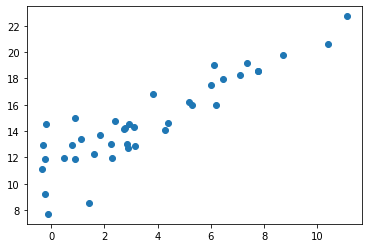

In [70]:
plt.scatter(np.log(statistic_vec),np.log(mse_vec))

In [71]:
np.corrcoef(statistic_vec,mse_vec)

array([[1.        , 0.94285652],
       [0.94285652, 1.        ]])

In [72]:
np.corrcoef(np.log(statistic_vec),np.log(mse_vec))

array([[1.        , 0.89865007],
       [0.89865007, 1.        ]])

In [64]:


statistic_vec = []
mse_base_vec = []
mse_vec = []
sample_generator=TestDistribution(3).returnDistribution()
n_train = 10000
n_test = 2000
np.random.seed(1)
for i in range(40):
    
    print(i)
    X_train, y_train = sample_generator.generate(n_train)
    X_test, y_test = sample_generator.generate(n_test)
    
    L = 3
    portion_vec = np.random.rand(L)             
    portion_vec = portion_vec / np.linalg.norm(portion_vec, ord = 1)
    
    
    
    R_1 = np.array([[r**i for i in range(L) ] for r in portion_vec])
    det_1 = np.linalg.det(R_1.T @ R_1)
    R_2 = np.array([[r**i for i in range(1,L) ] for r in portion_vec])
    det_2 = np.linalg.det(R_2.T @ R_2)
    
    statistic_vec.append( L**0.5 * det_2 / det_1 * np.sum((portion_vec * n_train)**(-2/(2+4)))  + np.sum((portion_vec * n_train)**(-2 * 4  / ( 2 + 4))))
    
    
    params = {"lamda" : [0.0001,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5],
             "portion_vec" : [portion_vec],
             "weighting_scheme" : ["extrapolated"],
             "smooth_order" : [L]}
    
    cv_regressor = GridSearchCV(estimator = FLENN(), param_grid = params, cv = 10, n_jobs = 21)
    _ = cv_regressor.fit(X_train, y_train)
    model = cv_regressor.best_estimator_
    
    mse_vec.append(mean_squared_error(model.predict(X_test), y_test))
    
#     params = {"lamda" : [0.0001,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5],
#              "portion_vec" : [[0.1,0.3,0.6]],
#              "weighting_scheme" : ["extrapolated"],
#              "smooth_order" : [L]}
#     cv_regressor = GridSearchCV(estimator = FLENN(), param_grid = params, cv = 10, n_jobs = 21)
#     _ = cv_regressor.fit(X_train, y_train)
#     model = cv_regressor.best_estimator_
#     mse_base_vec.append(mean_squared_error(model.predict(X_test), y_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [66]:
np.corrcoef(statistic_vec, mse_vec)

array([[1.        , 0.11039403],
       [0.11039403, 1.        ]])